# Experimento: Clasificación supervisada con embeddings (OpenAI) + Regresión Logística

## Descripción general

En esta notebook se evalúa un enfoque de clasificación automática de asuntos
administrativos utilizando embeddings generados por la API de OpenAI como
representación semántica del texto, y un modelo supervisado clásico
(Regresión Logística) como clasificador.

Este experimento combina lo mejor de dos mundos:
- Representación semántica robusta mediante embeddings.
- Entrenamiento supervisado con etiquetas históricas.

---

## Objetivo del experimento

- Evaluar el desempeño de un modelo supervisado entrenado sobre embeddings
  en comparación con:
  - TF-IDF + ML (baseline clásico),
  - embeddings + similitud coseno (no supervisado),
  - y enfoques basados en LLM.
- Analizar si un clasificador lineal sobre embeddings ofrece una solución
  productiva estable y reproducible.

---

## Enfoque metodológico

- Se obtienen embeddings del campo `asunto` utilizando un modelo de embeddings
  de OpenAI.
- Cada asunto queda representado por un vector numérico de alta dimensión.
- Se entrena un clasificador de **Regresión Logística** sobre dichos vectores.
- La evaluación se realiza mediante métricas estándar de clasificación en un
  conjunto de validación/test.

---

## Resultados y observaciones

El enfoque embeddings + Regresión Logística presenta:

- Ventajas:
  - Mejor captura semántica que TF-IDF.
  - Entrenamiento rápido y modelo simple (fácil de desplegar).
  - Buen desempeño en dominios con distribución estable.

- Limitaciones:
  - Requiere retraining cuando cambian las áreas o el estilo de redacción.
  - Sensible a desbalances de clases y a la calidad de las etiquetas históricas.
  - Puede fallar ante casos ambiguos o poco representados en los datos.

---

## Rol dentro del proyecto

Este experimento permitió medir el desempeño de una solución supervisada
moderna basada en embeddings, sirviendo como referencia directa frente a los
modelos LLM.

Los resultados contribuyeron a la decisión final de adoptar un enfoque basado
en LLM por su mayor capacidad de generalización y menor dependencia del
reentrenamiento continuo.


# Experimento con OpenAI Embeddings + Regresión Logistica🎯

Realizamos embedidding de los asuntos y luego entrenamos un modelo de ML en este caso Regresión Logística

##Idea general del experimento

1- Generar embeddings para:

* cada asunto del dataset


2- Para entrenamos un modelo ML:

* Regresión Logística

3- Evaluar:

* accuracy, F1

* matriz de confusión

4- Guardar resultados y métricas en Drive como nuevo experimento.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
# 1) Cargar tus datos (id, asunto, cuerpo, area_destino)
df = pd.read_csv("/content/drive/MyDrive/Diplo-2025/Proyecto/24 11 Proyecto/Dataset_24-11.csv")  # ← arma este CSV

In [ ]:
df.head()

,Fecha de creación,Asunto,AREA OBJETIVO
0,8/9/2025,ADJUNTAR DOCUMENTACIÓN SOLICITADA,MESA DE ENTRADAS
1,8/9/2025,CAMBIO DE TITULARIDAD PARA ADJUDICATARIOS,REGULARIZACION DOMINIAL
2,8/9/2025,CANCELACION DE HIPOTECA,GESTION FINANCIERA
3,8/9/2025,COMBUSTIBLE PARA VEHICULOS OFICIALES - PETROLE...,ADMINISTRACION
4,8/9/2025,CUPON DE PAGO - CAMBIO DE TITULARIDAD,REGULARIZACION DOMINIAL/GESTION FINANCIERA


In [ ]:
df = df.rename(columns={
    "Asunto": "asunto",
    "AREA OBJETIVO": "area_objetivo"
})

df["area_objetivo"] = df["area_objetivo"].astype(str).str.strip()
df["asunto"] = df["asunto"].astype(str).str.strip()


In [ ]:
df["asunto"] = df["asunto"].str.lower().str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

In [ ]:
df.describe(include='O')

,Fecha de creación,asunto,area_objetivo
count,756,756,756
unique,47,543,10
top,9/9/2025,"solicitud de cuotas, cancelacion y libre de de...",REGULARIZACION DOMINIAL
freq,38,58,253


In [ ]:
df['area_objetivo'] = df['area_objetivo'].str.strip()
print("Value counts after stripping whitespace:")
df['area_objetivo'].value_counts()

Value counts after stripping whitespace:


,count
area_objetivo,
REGULARIZACION DOMINIAL,253
GESTION FINANCIERA,211
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
REGULARIZACION DOMINIAL/GESTION FINANCIERA,12
JURIDICO,8
REGULARIZACION DOMINIAL/ESCRITURACIONES,5
TECNICA,4


In [ ]:
df['area_objetivo'] = df['area_objetivo'].replace('GESTION FINANCIERA/ESCRITURACIONES', 'GESTION FINANCIERA')
df['area_objetivo'] = df['area_objetivo'].replace(['REGULARIZACION DOMINIAL/GESTION FINANCIERA', 'REGULARIZACION DOMINIAL/ESCRITURACIONES'], 'REGULARIZACION DOMINIAL')
df['area_objetivo'].value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,270
GESTION FINANCIERA,214
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
JURIDICO,8
TECNICA,4


In [ ]:
conteo_area = df["area_objetivo"].value_counts()
porcentaje_area = df["area_objetivo"].value_counts(normalize=True) * 100

dist_areas = pd.DataFrame({
    "registros": conteo_area,
    "porcentaje": porcentaje_area.round(2)
})

dist_areas


,registros,porcentaje
area_objetivo,,
REGULARIZACION DOMINIAL,270,35.71
GESTION FINANCIERA,214,28.31
ESCRITURACIONES,150,19.84
MESA DE ENTRADAS,56,7.41
ADMINISTRACION,54,7.14
JURIDICO,8,1.06
TECNICA,4,0.53


In [ ]:
# 1) Duplicados 100% idénticos (asunto + área + palabra)
df["es_dup_exacto"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False  # marca todos los que estén en grupos duplicados
)

# 2) Duplicados por asunto dentro de la misma área
df["es_dup_asunto_en_area"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False
)

In [ ]:
resumen_area = df.groupby("area_objetivo").agg(
    total_registros=("asunto", "size"),
    asuntos_unicos=("asunto", "nunique"),
    registros_en_grupos_dup_exacto=("es_dup_exacto", "sum"),
    registros_en_grupos_dup_asunto_area=("es_dup_asunto_en_area", "sum")
)

resumen_area["porc_reg_en_dup_exacto"] = (
    resumen_area["registros_en_grupos_dup_exacto"] / resumen_area["total_registros"] * 100
).round(2)

resumen_area["porc_reg_en_dup_asunto_area"] = (
    resumen_area["registros_en_grupos_dup_asunto_area"] / resumen_area["total_registros"] * 100
).round(2)

resumen_area.sort_values("total_registros", ascending=False)


,total_registros,asuntos_unicos,registros_en_grupos_dup_exacto,registros_en_grupos_dup_asunto_area,porc_reg_en_dup_exacto,porc_reg_en_dup_asunto_area
area_objetivo,,,,,,
REGULARIZACION DOMINIAL,270,211,77,77,28.52,28.52
GESTION FINANCIERA,214,152,67,67,31.31,31.31
ESCRITURACIONES,150,75,78,78,52.00,52.00
MESA DE ENTRADAS,56,51,9,9,16.07,16.07
ADMINISTRACION,54,42,19,19,35.19,35.19
JURIDICO,8,8,0,0,0.00,0.00
TECNICA,4,4,0,0,0.00,0.00


Esto ya te responde cosas como:

“En el área X, el 60% de los registros pertenecen a asuntos repetidos”

“El área Y tiene pocos asuntos, pero muy repetidos”

In [ ]:
print(f"Number of duplicate rows in df: {df.duplicated(subset=['asunto']).sum()}")

Number of duplicate rows in df: 213


In [ ]:
print(f"Number of duplicate rows in df_filtered: {df.duplicated(subset=['asunto']).sum()}")
if df.duplicated().sum() > 0:
    print("Duplicate rows:")
    print(df[df.duplicated(subset=['asunto'],keep=False)].sort_values(by='asunto'))
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_filtered: 213
Duplicate rows:
    Fecha de creación                                             asunto  \
732        29/07/2025                         actualizar cedulon vencido   
456        10/07/2025                         actualizar cedulon vencido   
719        28/07/2025  adelantamiento de cuotas de planes provinciale...   
407        06/07/2025  adelantamiento de cuotas de planes provinciale...   
118         12/9/2025  adelantamiento de cuotas de planes provinciale...   
..                ...                                                ...   
243         19/9/2025  suministro de gas natural - distribuidora de g...   
481        11/07/2025  suministro de gas natural - distribuidora de g...   
620        21/07/2025                                           vivienda   
244         19/9/2025                                           vivienda   
68           9/9/2025                                           vivienda   

          area_objetivo  e

In [ ]:
df.shape

(756, 5)

In [ ]:
df = df.drop_duplicates(subset=['asunto'])
df.shape

(543, 5)

In [ ]:
df['area_objetivo_codificada'], _ = pd.factorize(df['area_objetivo'])

In [ ]:
df.head

<bound method NDFrame.head of     Fecha de creación                                             asunto  \
0            8/9/2025                  adjuntar documentacion solicitada   
1            8/9/2025          cambio de titularidad para adjudicatarios   
2            8/9/2025                            cancelacion de hipoteca   
3            8/9/2025  combustible para vehiculos oficiales - petrole...   
4            8/9/2025              cupon de pago - cambio de titularidad   
..                ...                                                ...   
751        31/07/2025                                    turno escritura   
752        31/07/2025         escritura de mi terreno segundo testimonio   
753        31/07/2025                        ponerme al dia con mi deuda   
754        31/07/2025  direccion de vivienda - solicita inscripcion d...   
755        31/07/2025                          link de pago para celudon   

               area_objetivo  es_dup_exacto  es_dup_asunto_en_area  \
0           MESA DE ENTRADAS           True                   True   
1    REGULARIZACION DOMINIAL           True                   True   
2         GESTION FINANCIERA           True                   True   
3             ADMINISTRACION          False                  False   
4    REGULARIZACION DOMINIAL          False                  False   
..                       ...            ...                    ...   
751          ESCRITURACIONES          False                  False   
752          ESCRITURACIONES          False                  False   
753       GESTION FINANCIERA          False                  False   
754  REGULARIZACION DOMINIAL          False                  False   
755       GESTION FINANCIERA          False                  False   

     area_objetivo_codificada  
0                           0  
1                           1  
2                           2  
3                           3  
4                           1  
..                        ...  
751                         4  
752                         4  
753                         2  
754                         1  
755                         2  

[543 rows x 6 columns]>

In [ ]:
area_mapping = dict(zip(df['area_objetivo'], df['area_objetivo_codificada']))
print("Mapping of 'AREA OBJETIVO' to Numerical Codes:")
print(area_mapping)

Mapping of 'AREA OBJETIVO' to Numerical Codes:
{'MESA DE ENTRADAS': 0, 'REGULARIZACION DOMINIAL': 1, 'GESTION FINANCIERA': 2, 'ADMINISTRACION': 3, 'ESCRITURACIONES': 4, 'JURIDICO': 5, 'TECNICA': 6}


# API OpenAI

In [ ]:
from google.colab import userdata

try:
    print("OK → userdata está disponible")
except:
    print("⚠️ userdata NO está disponible en este entorno")

OK → userdata está disponible


In [ ]:
from google.colab import userdata
openai_key = userdata.get("API_OpenAI")

print(openai_key[:6], "...")  # Nunca imprimas la key completa

sk-pro ...


In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 2.8.1
    Uninstalling openai-2.8.1:
      Successfully uninstalled openai-2.8.1


In [ ]:
import os
from openai import OpenAI

# Asegurate de tener la API Key en la variable de entorno
# En Colab por ejemplo:
# os.environ["OPENAI_API_KEY"] = "tu_clave"
os.environ["OPENAI_API_KEY"] = userdata.get("API_OpenAI")
client = OpenAI()

EMBEDDING_MODEL = "text-embedding-3-small"  # o "text-embedding-3-large"

In [ ]:
import numpy as np

_embedding_cache = {}

def get_embedding(text: str, model: str = EMBEDDING_MODEL):
    """
    Devuelve el embedding de un texto usando OpenAI, con cache simple.
    """
    text = text.strip()
    if text in _embedding_cache:
        return _embedding_cache[text]

    response = client.embeddings.create(
        model=model,
        input=text
    )
    vec = np.array(response.data[0].embedding, dtype=float)
    _embedding_cache[text] = vec
    return vec


Costo = X - 0.51

In [ ]:
df_exp = df.copy()

df_exp["asunto_texto_modelo"] = df_exp["asunto"].fillna("").astype(str)

asunto_embeddings = []

for txt in df_exp["asunto_texto_modelo"]:
    v = get_embedding(txt)
    asunto_embeddings.append(v)

df_exp["asunto_embedding_openai"] = asunto_embeddings


In [ ]:
df_exp.head()

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,asunto_texto_modelo,asunto_embedding_openai
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0,adjuntar documentacion solicitada,"[-0.01623709686100483, 0.03489800915122032, 0...."
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1,cambio de titularidad para adjudicatarios,"[0.017991073429584503, 0.016048716381192207, 0..."
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2,cancelacion de hipoteca,"[0.0033065660391002893, 0.03544952720403671, 0..."
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3,combustible para vehiculos oficiales - petrole...,"[0.0002307317772647366, -0.016886824741959572,..."
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1,cupon de pago - cambio de titularidad,"[0.037607599049806595, 0.002800463931635022, -..."


# Regresión Logística

In [ ]:
import numpy as np

# X: matriz (n_muestras, dim_embedding)
X = np.vstack(df_exp["asunto_embedding_openai"].values)

# y: etiquetas verdaderas
y = df_exp["area_objetivo"].to_numpy()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X,
    y,
    df.index,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    n_jobs=-1
)

logreg.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_test = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
clas_report_text = classification_report(y_test, y_pred_test)
print("Accuracy (test):", accuracy)
print(clas_report_text)


Accuracy (test): 0.8623853211009175
                         precision    recall  f1-score   support

         ADMINISTRACION       1.00      0.62      0.77         8
        ESCRITURACIONES       0.88      1.00      0.94        15
     GESTION FINANCIERA       0.86      0.97      0.91        31
               JURIDICO       0.00      0.00      0.00         2
       MESA DE ENTRADAS       0.62      0.50      0.56        10
REGULARIZACION DOMINIAL       0.89      0.93      0.91        42
                TECNICA       0.00      0.00      0.00         1

               accuracy                           0.86       109
              macro avg       0.61      0.57      0.58       109
           weighted avg       0.84      0.86      0.84       109



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_proba_test = logreg.predict_proba(X_test)


In [ ]:
df["area_pred_logreg"] = None
df.loc[idx_test, "area_pred_logreg"] = y_pred_test


In [ ]:
df["error_logreg"] = df["area_pred_logreg"] != df["area_objetivo"]


In [ ]:
df["error_logreg"].head()

,error_logreg
0,True
1,True
2,False
3,True
4,True


In [ ]:
df

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,area_pred_logreg,error_logreg
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0,None,True
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1,None,True
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2,GESTION FINANCIERA,False
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3,None,True
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1,None,True
...,...,...,...,...,...,...,...,...
751,31/07/2025,turno escritura,ESCRITURACIONES,False,False,4,None,True
752,31/07/2025,escritura de mi terreno segundo testimonio,ESCRITURACIONES,False,False,4,None,True
753,31/07/2025,ponerme al dia con mi deuda,GESTION FINANCIERA,False,False,2,GESTION FINANCIERA,False
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,False


In [ ]:
df.loc[idx_test]

In [ ]:
df_resul = df.copy()
df_resul = df_resul.loc[idx_test]

In [ ]:
df_resul.shape

(109, 8)

In [ ]:
df_resul

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,area_pred_logreg,error_logreg
729,29/07/2025,adjunto al tramite iniciado gobdigi-0034116111...,MESA DE ENTRADAS,False,False,0,MESA DE ENTRADAS,False
490,12/07/2025,casa bloqueada no puedo pagar,REGULARIZACION DOMINIAL,False,False,1,GESTION FINANCIERA,True
57,9/9/2025,solicitud cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,False
98,11/9/2025,escritura,ESCRITURACIONES,True,True,4,ESCRITURACIONES,False
492,12/07/2025,solicita refinancion de deuda,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,False
...,...,...,...,...,...,...,...,...
557,16/07/2025,"me atrase en mis cuotas, necesito refinanciar",REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,False
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,False
361,04/07/2025,deseo escriturar mi vivienda,ESCRITURACIONES,False,False,4,ESCRITURACIONES,False
640,21/07/2025,medios de pago con tarjeta para pagar mi terreno,GESTION FINANCIERA,False,False,2,GESTION FINANCIERA,False


In [ ]:
area_mapping

{'MESA DE ENTRADAS': 0,
 'REGULARIZACION DOMINIAL': 1,
 'GESTION FINANCIERA': 2,
 'ADMINISTRACION': 3,
 'ESCRITURACIONES': 4,
 'JURIDICO': 5,
 'TECNICA': 6}

In [ ]:
reverse_area_mapping = {v: k for k, v in area_mapping.items()}

In [ ]:
reverse_area_mapping

{0: 'MESA DE ENTRADAS',
 1: 'REGULARIZACION DOMINIAL',
 2: 'GESTION FINANCIERA',
 3: 'ADMINISTRACION',
 4: 'ESCRITURACIONES',
 5: 'JURIDICO',
 6: 'TECNICA'}

In [ ]:
class_labels = [reverse_area_mapping[i] for i in sorted(reverse_area_mapping.keys())]

 MÉTRICAS GENERALES DEL MODELO ML - LogisticRegression - EmbeddingsOpenAI

Accuracy top-1: 0.8623853211009175

Reporte de clasificación:

                         precision    recall  f1-score   support

         ADMINISTRACION       1.00      0.62      0.77         8
        ESCRITURACIONES       0.88      1.00      0.94        15
     GESTION FINANCIERA       0.86      0.97      0.91        31
               JURIDICO       0.00      0.00      0.00         2
       MESA DE ENTRADAS       0.62      0.50      0.56        10
REGULARIZACION DOMINIAL       0.89      0.93      0.91        42
                TECNICA       0.00      0.00      0.00         1

               accuracy                           0.86       109
              macro avg       0.61      0.57      0.58       109
           weighted avg       0.84      0.86      0.84       109


 MATRIZ DE CONFUSIÓN



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


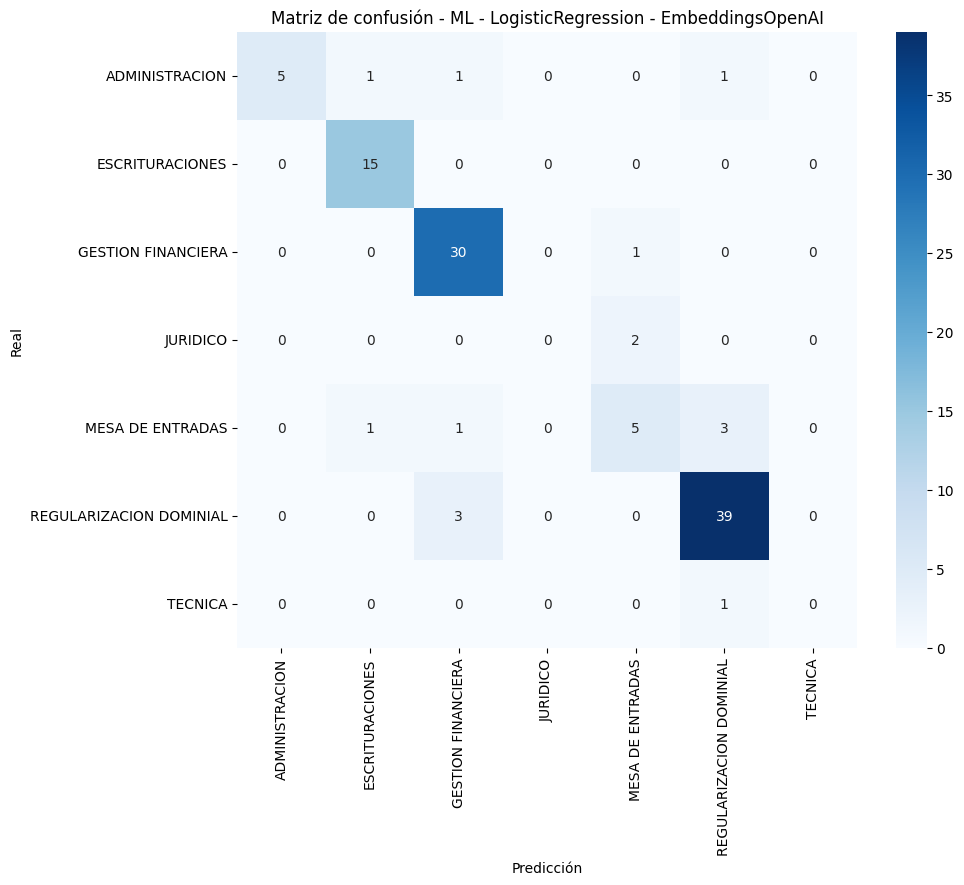

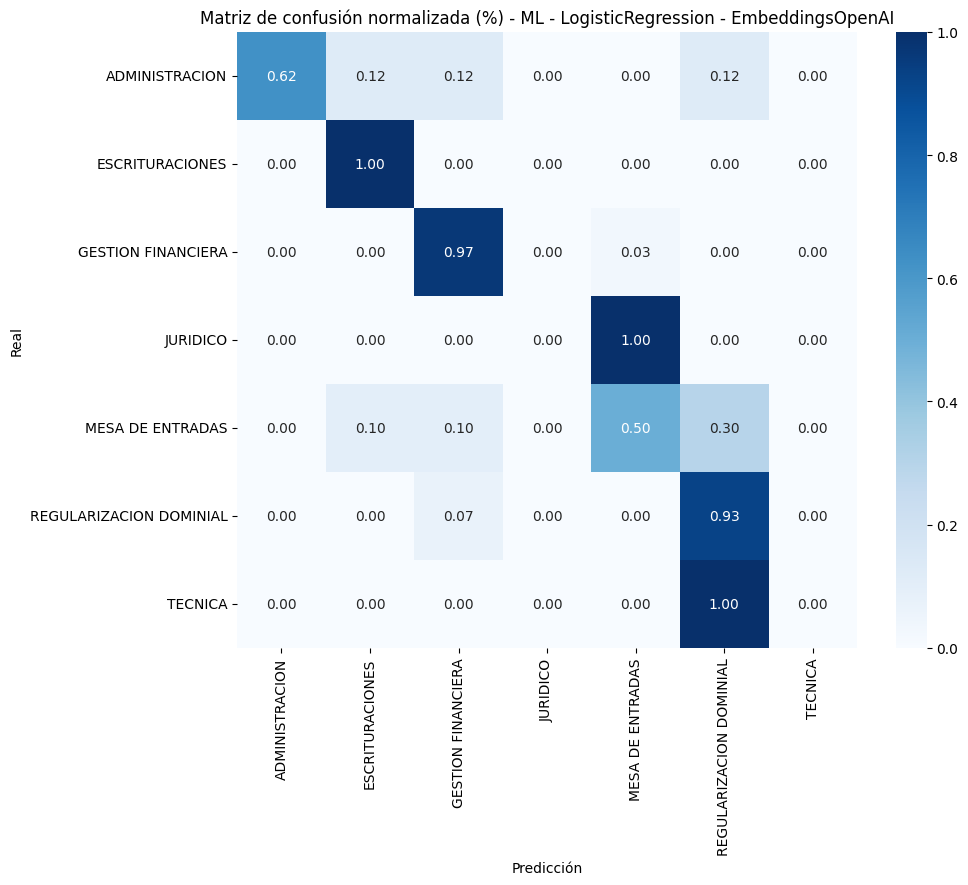


 TOP ERRORES (primeros 15)



,asunto,area_objetivo,area_pred_logreg
490,casa bloqueada no puedo pagar,REGULARIZACION DOMINIAL,GESTION FINANCIERA
171,pronto despacho,JURIDICO,MESA DE ENTRADAS
735,plan de pago de mi terreno,REGULARIZACION DOMINIAL,GESTION FINANCIERA
368,pronto despacho b los alamos 2da seccion,JURIDICO,MESA DE ENTRADAS
687,renuncia a mi terreno,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
79,solicitar plan de pago,REGULARIZACION DOMINIAL,GESTION FINANCIERA
458,escritura b alem rio cuarto turno,ADMINISTRACION,ESCRITURACIONES
714,quisiera obtener una vivienda para mis hijos y tener un hogar propio para ellos.,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
355,solicitud de intervencion habitacional,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
747,ref muneracion 90490,MESA DE ENTRADAS,GESTION FINANCIERA



 ACCURACY POR ÁREA



/tmp/ipython-input-2605923822.py:97: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["area_pred_logreg"] == x["area_objetivo"]).mean())


,0
area_objetivo,
ESCRITURACIONES,1.000000
GESTION FINANCIERA,0.967742
REGULARIZACION DOMINIAL,0.928571
ADMINISTRACION,0.625000
MESA DE ENTRADAS,0.500000
JURIDICO,0.000000
TECNICA,0.000000


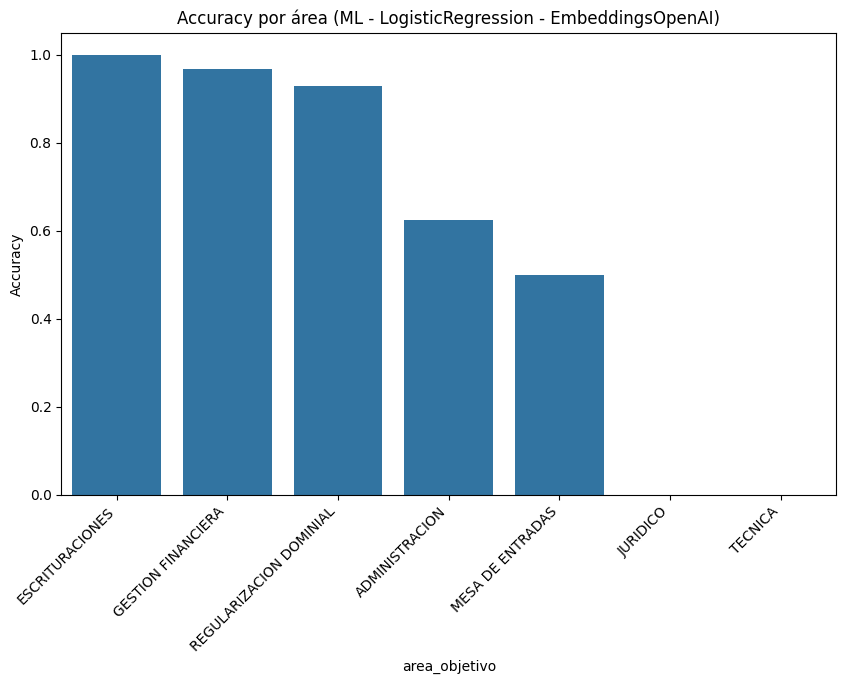


 MATRIZ DE CONFUSIÓN (crudo)



,ADMINISTRACION,ESCRITURACIONES,GESTION FINANCIERA,JURIDICO,MESA DE ENTRADAS,REGULARIZACION DOMINIAL,TECNICA
ADMINISTRACION,5,1,1,0,0,1,0
ESCRITURACIONES,0,15,0,0,0,0,0
GESTION FINANCIERA,0,0,30,0,1,0,0
JURIDICO,0,0,0,0,2,0,0
MESA DE ENTRADAS,0,1,1,0,5,3,0
REGULARIZACION DOMINIAL,0,0,3,0,0,39,0
TECNICA,0,0,0,0,0,1,0



 INTERPRETACIÓN BÁSICA:


• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente
  (ej: RD → Administración significa que muchos asuntos de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.


 PALABRAS FRECUENTES EN ERRORES

Top 50 palabras frecuentes en asuntos mal clasificados:

de: 7
mi: 3
vivienda: 3
casa: 2
no: 2
pronto: 2
despacho: 2
plan: 2
pago: 2
terreno: 2
b: 2
una: 2
para: 2
intervencion: 2
n: 2
ejercicio: 2
bloqueada: 1
puedo: 1
pagar: 1
los: 1
alamos: 1
da: 1
seccion: 1
renuncia: 1
a: 1
solicitar: 1
escritura: 1
alem: 1
rio: 1
cuarto: 1
turno: 1
quisiera: 1
obtener: 1
mis: 1
hijos: 1
y: 1
tener: 1
un: 1
hogar: 1
propio: 1
ellos: 1
solicitud: 1
habitacional: 1
ref: 1
muneracion: 1
solicito: 1
revicion: 1
valuacion: 1
quiero: 1
donde: 1


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# === CONFIGURACIÓN DEL EXPERIMENTO ===
MODEL_TAG = "ML - LogisticRegression - EmbeddingsOpenAI"  # para los títulos

# === 1. CARGA DE DATOS ===

# si ya estás trabajando con df, podés omitir esta línea
# df = df_resul.copy()

y_true = df['area_objetivo']
y_pred = df['area_pred_logreg']

# Si ya tenés class_labels, usalo. Si no, los calculamos:
labels = sorted(y_true.unique())

# === 2. MÉTRICAS GENERALES ===

print("====================================")
print(f" MÉTRICAS GENERALES DEL MODELO {MODEL_TAG}")
print("====================================\n")

print("Accuracy top-1:", accuracy_score(y_true, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))

# === 3. MATRIZ DE CONFUSIÓN ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN")
print("====================================\n")

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f"Matriz de confusión - {MODEL_TAG}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MATRIZ NORMALIZADA ===

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f"Matriz de confusión normalizada (%) - {MODEL_TAG}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === 4. ERRORES MÁS IMPORTANTES ===

df_errores = df[df["area_objetivo"] != df["area_pred_logreg"]]

print("\n====================================")
print(" TOP ERRORES (primeros 15)")
print("====================================\n")

pd.set_option('display.max_colwidth', None)
display(df_errores[["asunto", "area_objetivo", "area_pred_logreg"]].head(15))

# === 5. ANALISIS DE ACCURACY POR ÁREA ===

print("\n====================================")
print(" ACCURACY POR ÁREA")
print("====================================\n")

# ✅ Lo corregimos para que use solo el grupo x

accuracy_por_area = (
    df
    .groupby("area_objetivo")
    .apply(lambda x: (x["area_pred_logreg"] == x["area_objetivo"]).mean())
    .sort_values(ascending=False)
)

display(accuracy_por_area)

plt.figure(figsize=(10,6))
sns.barplot(x=accuracy_por_area.index, y=accuracy_por_area.values)
plt.title(f"Accuracy por área ({MODEL_TAG})")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.show()

# === 6. ÁREAS QUE MÁS SE CONFUNDEN ENTRE SÍ ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN (crudo)")
print("====================================\n")

df_conf = pd.DataFrame(cm, index=labels, columns=labels)
display(df_conf)

print("\n====================================")
print(" INTERPRETACIÓN BÁSICA:")
print("====================================\n")
print("""
• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente
  (ej: RD → Administración significa que muchos asuntos de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.
""")

# === 7. ANÁLISIS LÉXICO DE ERRORES (rápido, sin stopwords) ===

print("\n====================================")
print(" PALABRAS FRECUENTES EN ERRORES")
print("====================================\n")

from collections import Counter
import re

def limpiar(texto):
    if pd.isna(texto):
        return ""
    return re.sub(r"[^a-zA-ZáéíóúñüÁÉÍÓÚÑÜ\s]", " ", texto.lower())

errores_textos = df_errores["asunto"].apply(limpiar).str.split()

counter = Counter()
for palabras in errores_textos:
    counter.update(palabras)

print("Top 50 palabras frecuentes en asuntos mal clasificados:\n")
for palabra, freq in counter.most_common(50):
    print(f"{palabra}: {freq}")


# Guardamos Resultados

In [ ]:
import os
from datetime import datetime

def crear_carpeta_experimento(nombre_base="experimento"):
    fecha = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/{nombre_base}_{fecha}"
    os.makedirs(carpeta, exist_ok=True)
    return carpeta

In [ ]:
def guardar_resultados(carpeta_experimento, df_resultados):
    ruta = os.path.join(carpeta_experimento, "resultados.csv")
    df_resultados.to_csv(ruta, index=False, encoding="utf-8")
    print(f"✔ Resultados guardados en: {ruta}")

In [ ]:
import json

def guardar_metricas(carpeta_experimento, accuracy, clas_report, parametros, descripcion):
    metricas = {
        "accuracy": accuracy,
        "classification_report": clas_report,
        "parametros_modelo": parametros,
        "descripcion": descripcion,
    }

    ruta = os.path.join(carpeta_experimento, "metricas.json")
    with open(ruta, "w", encoding="utf-8") as f:
        json.dump(metricas, f, indent=4, ensure_ascii=False)

    print(f"✔ Métricas guardadas en: {ruta}")

In [ ]:
modelo = "ML_LogReg_OpenAI_Embeddings_v1"

# 1. Crear carpeta de experimento
carpeta = crear_carpeta_experimento("experimento_ML_LogReg_OpenAI_Embeddings")


# 2. Guardar resultados completos (con predicciones)
guardar_resultados(carpeta, df)


# 3. Armar resumen por área (solo en test, para no mezclar)
df_test = df.loc[idx_test].copy()
df_test["error_logreg"] = df_test["area_pred_logreg"] != df_test["area_objetivo"]

resumen_areas_logreg = (
    df_test
    .groupby("area_objetivo")
    .agg(
        cantidad=("area_objetivo", "size"),
        errores=("error_logreg", "sum"),
    )
)

resumen_areas_logreg["porcentaje_error"] = (
    resumen_areas_logreg["errores"] / resumen_areas_logreg["cantidad"] * 100
).round(2)

guardar_resultados(
    carpeta,
    resumen_areas_logreg.reset_index()
)


# 4. Metadatos del experimento
parametros_modelo = {
    "tipo": "LogisticRegression_multinomial",
    "descripcion": "Regresión logística entrenada sobre embeddings de OpenAI",
    "modelo": modelo,
    "multi_class": "multinomial",
    "max_iter": logreg.max_iter,
    "C": logreg.C,
    "penalty": logreg.penalty,
    "solver": logreg.solver,
    "test_size": 0.2,
    "estrategia_split": "train_test_split estratificado por área",
    "cantidad_asuntos_total": int(len(df)),
    "cantidad_asuntos_train": int(len(idx_train)),
    "cantidad_asuntos_test": int(len(idx_test)),
    "cantidad_areas": int(df["area_objetivo"].nunique()),
}

descripcion = f"""
Experimento de clasificación de asuntos utilizando regresión logística
entrenada sobre embeddings generados con la API de OpenAI.

Modelo:
- {modelo}

Estrategia:
- Se generan embeddings de cada asunto con la API de OpenAI.
- Se arma una matriz X (n_muestras x dim_embedding).
- Se entrena una regresión logística multinomial.
- Evaluación sobre un 20% de los datos (test) estratificado por área.

Datos:
- Total de asuntos: {len(df)}
- Asuntos de entrenamiento: {len(idx_train)}
- Asuntos de test: {len(idx_test)}
- Cantidad de áreas: {df['area_objetivo'].nunique()}
"""


# 5. Guardar métricas
guardar_metricas(
    carpeta,
    accuracy,
    clas_report_text,
    parametros_modelo,
    descripcion
)

print("\n✔ El experimento LogReg + OpenAI Embeddings se guardó correctamente en:")
print(carpeta)


✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_LogReg_OpenAI_Embeddings_20251209_161502/resultados.csv
✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_LogReg_OpenAI_Embeddings_20251209_161502/resultados.csv
✔ Métricas guardadas en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_LogReg_OpenAI_Embeddings_20251209_161502/metricas.json

✔ El experimento LogReg + OpenAI Embeddings se guardó correctamente en:
/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_ML_LogReg_OpenAI_Embeddings_20251209_161502
